In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc, roc_auc_score
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score

Loading data

In [3]:
df_benign  = pd.read_csv(os.path.join('/content/drive/MyDrive/Data/CSV_benign.csv'), low_memory=False)
df_malware = pd.read_csv(os.path.join('/content/drive/MyDrive/Data/CSV_malware.csv'), low_memory=False)

In [4]:
df_benign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494135 entries, 0 to 494134
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             385194 non-null  object 
 1   ASN                 385249 non-null  float64
 2   TTL                 494135 non-null  int64  
 3   IP                  386440 non-null  object 
 4   Domain              494135 non-null  object 
 5   State               217505 non-null  object 
 6   Registrant_Name     13637 non-null   object 
 7   Country.1           254093 non-null  object 
 8   Creation_Date_Time  362222 non-null  object 
 9   hex_32              494012 non-null  object 
 10  hex_8               494135 non-null  object 
 11  Domain_Name         397438 non-null  object 
 12  Alexa_Rank          440288 non-null  object 
 13  subdomain           494119 non-null  object 
 14  Organization        201746 non-null  object 
 15  len                 493777 non-nul

In [5]:
df_malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             4053 non-null   object 
 1   ASN                 4055 non-null   float64
 2   TTL                 4999 non-null   object 
 3   IP                  4098 non-null   object 
 4   Domain              4999 non-null   object 
 5   oc_8                4999 non-null   int64  
 6   longest_word        4999 non-null   object 
 7   Domain_Name         3968 non-null   object 
 8   dec_32              4999 non-null   int64  
 9   subdomain           4999 non-null   int64  
 10  sld                 4999 non-null   object 
 11  Registrant_Name     73 non-null     object 
 12  hex_32              4999 non-null   int64  
 13  Domain_Age          4428 non-null   object 
 14  entropy             4999 non-null   float64
 15  Name_Server_Count   4428 non-null   float64
 16  Emails

Data cleaning and preprocessing, including removing duplicates, dropping an unnecessary column, and handling missing values.

In [6]:
df_malware = df_malware.drop_duplicates()
df_benign = df_benign.drop_duplicates()

df_malware = df_malware.drop(columns=['Registrant_Name'])
df_benign = df_benign.drop(columns=['Registrant_Name'])

df_malware.dropna(inplace=True)
df_benign.dropna(inplace=True)

In [7]:
df_malware.shape

(1546, 37)

In [8]:
df_benign.shape

(131107, 37)

Labeling the data: 1 for malware (df_malware) and 0 for benign (df_benign).

In [9]:
df_malware["Label"] = 1
df_benign["Label"] = 0

Balancing data

In [10]:
df_benign_resampled = resample(df_benign, replace=False, n_samples=2000, random_state=42)
df_malware_resampled = resample(df_malware, replace=True, n_samples=2000, random_state=42)
data = pd.concat([df_malware_resampled , df_benign_resampled])

Splitting data into training and testing sets

In [11]:
X = data.drop('Label', axis=1)
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Separating and preprocessing numerical and categorical features, setting up transformers, and creating a data preprocessing pipeline

In [12]:
cols_numerical = X_train.select_dtypes(include=['int64', 'float64']).columns
cols_categorical = X_train.select_dtypes(include=['object']).columns

X_train[cols_categorical] = X_train[cols_categorical].astype(str)
X_test[cols_categorical] = X_test[cols_categorical].astype(str)

transformer_numerical = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)],
    remainder='passthrough'
)

 Logistic regression model evaluation

Accuracy: 0.9175
ROC-AUC score 0.9149050878908699
Precision: 0.8903508771929824
Recall: 0.9620853080568721
F1_score: 0.9248291571753987


<Axes: >

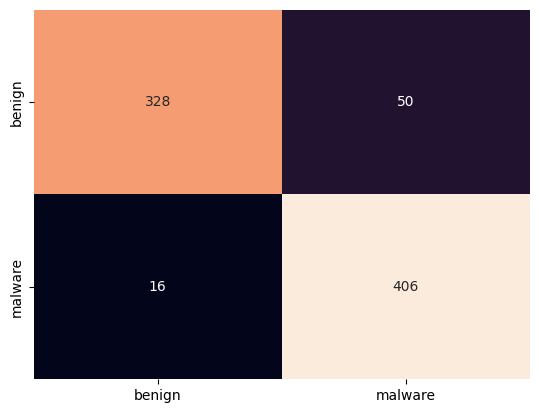

In [13]:
pipe_lr = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier',  LogisticRegression(max_iter=500 ,random_state=42))
    ])

pipe_lr.fit(X_train, y_train)
accuracy_lr = pipe_lr.score(X_test, y_test)

y_pred_lr = (pipe_lr.predict(X_test))
print('Accuracy:', accuracy_lr)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1_score:', f1_score(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

Decision tree model evaluation

Accuracy: 0.91625
ROC-AUC score 0.9148235913638756
Precision: 0.9043280182232346
Recall: 0.9407582938388626
F1_score: 0.9221835075493612


<Axes: >

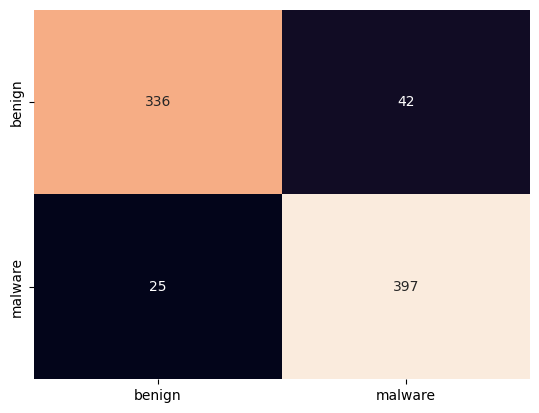

In [14]:
pipe_dt = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier',  DecisionTreeClassifier())
            ])
pipe_dt.fit(X_train, y_train)
accuracy_dt = pipe_dt.score(X_test, y_test)

y_pred_dt = (pipe_dt.predict(X_test))
print('Accuracy:', accuracy_dt)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_dt))
print('Precision:', precision_score(y_test, y_pred_dt))
print('Recall:', recall_score(y_test, y_pred_dt))
print('F1_score:', f1_score(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

Random forest model evaluation

Accuracy 0.91
ROC-AUC score 0.9083477519496479
Precision: 0.8959276018099548
Recall: 0.9383886255924171
F1_score: 0.9166666666666667


<Axes: >

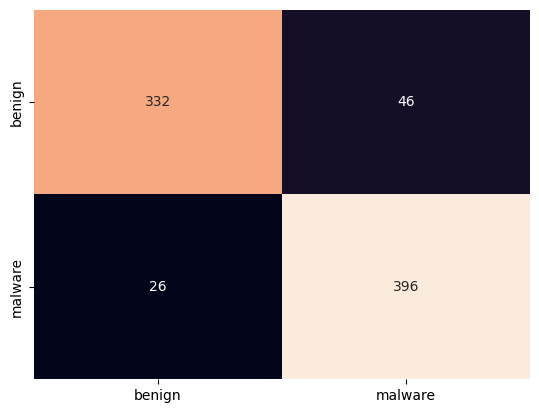

In [15]:
pipe_rf = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier', RandomForestClassifier(n_jobs=-1))
            ])
pipe_rf.fit(X_train, y_train)
accuracy_rf = pipe_rf.score(X_test, y_test)

y_pred_rf = (pipe_rf.predict(X_test))
print('Accuracy',accuracy_rf)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1_score:', f1_score(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

K-nearest neighbors (KNN) model evaluation with 3 neighbors

---



Accuracy: 0.825
ROC-AUC score 0.8181248276035005
Precision: 0.77431906614786
Recall: 0.943127962085308
F1_score: 0.8504273504273504


<Axes: >

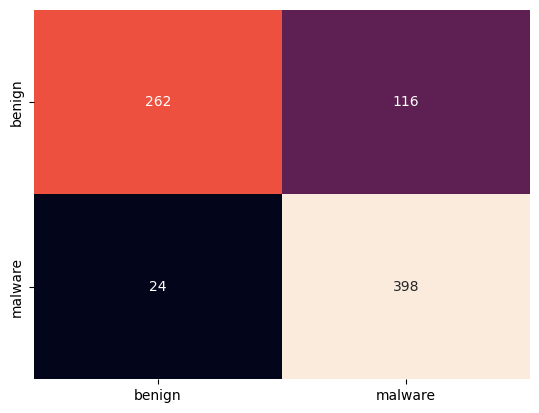

In [16]:
pipe_knn = Pipeline(steps = [
                ('preprocessor', preprocessor),
               ('classifier', KNeighborsClassifier(3))
            ])
pipe_knn.fit(X_train, y_train)
accuracy_knn = pipe_knn.score(X_test, y_test)

y_pred_knn = (pipe_knn.predict(X_test))
print('Accuracy:',accuracy_knn)
print('ROC-AUC score', roc_auc_score(y_test, y_pred_knn))
print('Precision:', precision_score(y_test, y_pred_knn))
print('Recall:', recall_score(y_test, y_pred_knn))
print('F1_score:', f1_score(y_test, y_pred_knn))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt = 'd', xticklabels=['benign', 'malware'], yticklabels=['benign', 'malware'], cbar=False)

Cross-validation of the K-nearest neighbors (KNN) model

In [17]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
X[cols_categorical] = X[cols_categorical].astype(str)

scores = cross_val_score(pipe_knn, X, y, cv=cv, scoring='accuracy')
print('Cross-validation results:', scores)
print('Mean accuracy:', scores.mean())

Cross-validation results: [0.8475 0.805  0.84   0.84   0.84   0.8475 0.83   0.8275 0.805  0.8175]
Mean accuracy: 0.8300000000000001


Summary of model evaluation metrics

In [18]:
results= {
    'Model': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier'],
    'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_knn],
    'ROC-AUC score': [roc_auc_score(y_test, y_pred_lr), roc_auc_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_rf), roc_auc_score(y_test, y_pred_knn)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_knn)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_knn)],
    'F1_score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_knn)]
}

df = pd.DataFrame(results)
df

,Model,Accuracy,ROC-AUC score,Precision,Recall,F1_score
0,LogisticRegression,0.91750,0.914905,0.890351,0.962085,0.924829
1,DecisionTreeClassifier,0.91625,0.914824,0.904328,0.940758,0.922184
2,RandomForestClassifier,0.91000,0.908348,0.895928,0.938389,0.916667
3,KNeighborsClassifier,0.82500,0.818125,0.774319,0.943128,0.850427


Logistic Regression achieved the highest accuracy and F1-score. The Decision Tree Classifier and the Random Forest Classifier also achieved good results but are slightly less effective than logistic regression. The K-Nearest Neighbors Classifier exhibits significantly lower accuracy and F1-score compared to the other models. Logistic Regression is the model that performs best in domain classification.